In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/BASIC/235896 : 수화 이미지 분류'

/content/drive/MyDrive/BASIC/235896 : 수화 이미지 분류


In [5]:
!unzip -qq open.zip -d /content

In [6]:
cd '/content'

/content


[수화 이미지 분류 Baseline1](https://dacon.io/competitions/official/235896/codeshare/4947?page=1&dtype=recent)

### 1.Library Import

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import albumentations as A
import warnings
from glob import glob
from PIL import Image
import cv2

In [8]:
import os
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

### 2.Hyperparameter Setting

In [9]:
CFG = {
    'IMG_SIZE':128, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':2e-2, #학습률
    'BATCH_SIZE':12, #배치사이즈
    'SEED':41, #시드
}

### 3.Fixed RandomSeed
재현성을 위해 seed를 고정한다.

In [10]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

### 4.Data import

In [11]:
import pandas as pd
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [12]:
train.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


### 5.Data Pre-processing

- 10-1을 정수 10으로, 10-2를 정수 0으로 변경
- label 열의 타입을 int로 변경


In [13]:
train.loc[train['label'] == '10-1','label'] = 10
train.loc[train['label'] == '10-2','label'] = 0

In [14]:
train['label'] = train['label'].apply(lambda x : int(x))

### 6.데이터 경로 설정

- file_name 을 경로의 형태로 변경
    - **001.png → ./train/001.png**
    - **001.png → ./test/001.png**

In [15]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort() # feature
        
    label_list.extend(train['label']) # label
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort()

    return img_path_list

In [16]:
img_path_list, label_list = get_train_data('./train')
test_img_path = get_test_data('./test')

In [17]:
label_list[:5]

[0, 10, 3, 8, 9]

### 7.**CustomDataset**

- **__init__** 함수는 Dataset 객체가 생성될 때 한 번만 실행된다. 객체가 갖는 속성값을 **초기화**하는 역할로, 객체가 생성될 때 **자동으로 호출**된다.
    - img_path_list : train셋 file 경로
    - label_list : train셋 label 경로
    - train_mode : train 일때는 True, test 일때는 False
    - transforms(이미지 변형) : train일때는 train_trasform, test일때는 test_transform
- **__getitem__** 함수는 데이터셋에서 특정 1개의 샘플을 가져오는 함수
- **__len__** 함수는 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
- **cv2.imread(filename)** : 이미지 파일을 읽어준다.
    - filename : 이미지 파일의 경로

In [18]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]

        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

### 8.Train/val split

- train : validaion = 75 : 25

In [19]:
train_len = int(len(img_path_list) * 0.75)
val_len = int(len(label_list) * 0.25)

train_images_path = img_path_list[:train_len]
train_label = label_list[:train_len]

val_image_path = img_path_list[train_len:]
val_label = label_list[train_len:]

In [20]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', val_len)

train set 길이 :  643
vaildation set 길이 :  214


643개 / 214개 로 나누어진 데이터셋으로 이미지를 분석 하기 위해 이미지 변형(tranform)을 적용해보자 

### 9.이미지 변형 (tranform)

In [21]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

### 10.DataLoader

- **mini batch**를 만들어주는 역할
- dataloader를 통해 dataset의 **전체 데이터가 batch size로 나뉘게 된다.**
- 만들었던 dataset을 imput으로 넣어주면 여러 옵션(데이터 묶기, 섞기, 알아서 병렬처리)을 통해 **batch를 만들어 낸다.**

In [22]:
# 위에서 정의한 CustomDataset 함수를 이용해서 train dataset 생성
train_dataset = CustomDataset(train_images_path, train_label, train_mode=True, transforms=train_transform)

# 만든 train_dataset을 Dataloader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'],shuffle=True, num_workers = 0)

# vaildation 에서도 적용
val_dataset = CustomDataset(val_image_path, val_label, train_mode=True, transforms=test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [23]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',val_len, '/ total valid batches :', val_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


→ Batch Size가 12 이므로 train은 12개씩 54 묶음, valid는 12개씩 18 묶음이 출력된다.
### 번외 : 이미지 및 shape 확인

- iter : 반복 가능한 객체에서 이터레이터 반환
- next : 이터레이터에서 값을 차례대로 꺼냄

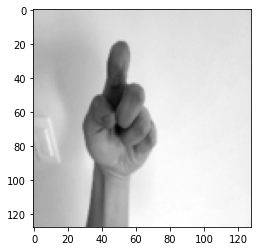

Label:10


In [24]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader))

img = train_features[0]
label = train_labels[0]

plt.imshow(img[0], cmap = 'gray')
plt.show()
print(f"Label:{label}")

- torch.Size([12, 3, 128, 128])는 (batch_size, channels, high, width)를 의미
- Label의 shape를 보면 정상적으로 배치사이즈(12)만큼 나오는 것을 확인

In [25]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([12, 3, 128, 128])
torch.Size([12])


### 11. model define

- 클래스(class) 형태의 모델은 nn.Module 을 상속받는다.
- __init__()에는 **모델의 구조와 동작을 정의**하는 생성자를 정의한다. 객체가 갖는 속성값을 **초기화**하는 역할로, 객체가 생성될 때 **자동으로 호출**된다.
- super() 함수를 부르면 여기서 만든 클래스는 nn.Module 클래스의 속성들을 가지고 초기화 된다.
- foward() 함수는 모델이 학습데이터를 입력받아서 **forward 연산을 진행**시키는 함수이다. model 객체를 데이터와 함께 호출하면 **자동으로 실행**이됩니다. 
예를 들어 model이란 이름의 객체를 생성 후, model(입력 데이터)와 같은 형식으로 객체를 호출하면 자동으로 forward 연산이 수행됩니다.
- forward 연산 : H(x) 식에 입력 x로부터 예측된 y를 얻는 것
- nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)

In [26]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함됨
#import torch.nn.init as init # 텐서에 초기값을 줌

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        x = self.layer2(x) #2층
        x = self.layer3(x) #3층
        x = self.layer4(x) #4층
    
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out

###12. model fit ( train 학습, val 평가)

train time과 eval time에서 수행하는 **다른 작업을 수행할 수 있도록 switching** 하는 함수가 존재한다.

- **model.train()** :  학습할 때와 추론할 때 다르게 동작하는 layer들을 **Training mode**로 바꿔줌.
    - Batch Normalization Layer는 **Batch Statistics**를 이용
    - Dropout Layer가 주어진 확률에 따라 **활성화**
- **model.eval()** : 학습할 때와 추론할 때 다르게 동작하는 layer들을 **Evaluation(Inference) mode**로 바꿔줌.
    - Batch Normalization Layer는 학습할 때 사용된 **Batch Statistics를 통해 결정된 Running Statistics**를 이용
    - Dropout Layer는 **비활성화**
- train time과 eval time에서 다르게 동작해야 하는 대표적인 예
    - BatchNorm Layer
    - Dropout Layer

In [27]:
import torch.optim as optim # 최적화 알고리즘들이 포함

model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train 메소드를 통하여 train을 학습시켜 validation 으로 평가하는 메소드를 작성

In [30]:
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader) # 배치사이즈
    
    #Loss Function 정의
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        train_loss = 0.0
								         # train_loader : 전체 data가 batch만큼 나누어진 데이터
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) # 예측값 산출
            loss = criterion(logit, label) # 손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화 (업데이트)

            train_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, train_loss / len(train_loader)))
            
        #---------------Validation set 평가-----------------

        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in tqdm(iter(val_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)# 예측값 산출
                vali_loss += criterion(logit, label) # 손실함수 계산

                # pred.eq : pred 배열과 label 배열이 일치하는가를 검사. (.sum 을 붙이면 일치하는 것 개수의 합을 숫자로 출력)
                # label.view_as(pred) : label를 pred의 모양대로 다시 정렬

                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                # correct : 맞춘 개수 
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(val_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(val_loader), correct, len(val_loader.dataset), 100 * correct / len(val_loader.dataset)))

        if scheduler is not None:
            scheduler.step()

        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/BASIC/235896 : 수화 이미지 분류/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')


In [31]:
train(model, optimizer, train_loader, scheduler, device)

  0%|          | 0/54 [00:00<?, ?it/s]

[1] Train loss: 2.3948321696


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4014, Accuracy: 18/215 ( 8%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[2] Train loss: 2.3922483524


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4027, Accuracy: 18/215 ( 8%)



  0%|          | 0/54 [00:00<?, ?it/s]

[3] Train loss: 2.3895816361


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4039, Accuracy: 20/215 ( 9%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[4] Train loss: 2.3869463559


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4018, Accuracy: 20/215 ( 9%)



  0%|          | 0/54 [00:00<?, ?it/s]

[5] Train loss: 2.3817950001


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4015, Accuracy: 21/215 ( 10%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[6] Train loss: 2.3727118837


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3956, Accuracy: 24/215 ( 11%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[7] Train loss: 2.3594796260


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3895, Accuracy: 27/215 ( 13%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[8] Train loss: 2.3411163842


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3833, Accuracy: 27/215 ( 13%)



  0%|          | 0/54 [00:00<?, ?it/s]

[9] Train loss: 2.3032610902


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3354, Accuracy: 29/215 ( 13%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[10] Train loss: 2.2418761540


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2699, Accuracy: 38/215 ( 18%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[11] Train loss: 2.1324483112


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2552, Accuracy: 49/215 ( 23%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[12] Train loss: 1.9739683293


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1593, Accuracy: 59/215 ( 27%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[13] Train loss: 1.7411944601


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9639, Accuracy: 83/215 ( 39%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[14] Train loss: 1.5112041654


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.7067, Accuracy: 94/215 ( 44%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[15] Train loss: 1.2493089846


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8094, Accuracy: 99/215 ( 46%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[16] Train loss: 1.0092309597


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.6378, Accuracy: 105/215 ( 49%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[17] Train loss: 0.7631523780


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3443, Accuracy: 92/215 ( 43%)



  0%|          | 0/54 [00:00<?, ?it/s]

[18] Train loss: 0.6407915188


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.7654, Accuracy: 106/215 ( 49%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[19] Train loss: 0.4731364327


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.0177, Accuracy: 122/215 ( 57%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[20] Train loss: 0.4509742788


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8330, Accuracy: 123/215 ( 57%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[21] Train loss: 0.3840131509


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.8031, Accuracy: 127/215 ( 59%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[22] Train loss: 0.3193762220


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9851, Accuracy: 126/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[23] Train loss: 0.2191357955


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 1.9985, Accuracy: 121/215 ( 56%)



  0%|          | 0/54 [00:00<?, ?it/s]

[24] Train loss: 0.1756751436


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2242, Accuracy: 130/215 ( 60%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[25] Train loss: 0.1577631204


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5732, Accuracy: 116/215 ( 54%)



  0%|          | 0/54 [00:00<?, ?it/s]

[26] Train loss: 0.1490925982


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3052, Accuracy: 127/215 ( 59%)



  0%|          | 0/54 [00:00<?, ?it/s]

[27] Train loss: 0.1184521325


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.4007, Accuracy: 131/215 ( 61%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[28] Train loss: 0.0878254317


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6778, Accuracy: 125/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[29] Train loss: 0.1014384956


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.1082, Accuracy: 137/215 ( 64%)

Model Saved.


  0%|          | 0/54 [00:00<?, ?it/s]

[30] Train loss: 0.0833696682


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3488, Accuracy: 137/215 ( 64%)



  0%|          | 0/54 [00:00<?, ?it/s]

[31] Train loss: 0.0758977469


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3909, Accuracy: 136/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[32] Train loss: 0.0404081565


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5420, Accuracy: 137/215 ( 64%)



  0%|          | 0/54 [00:00<?, ?it/s]

[33] Train loss: 0.0537002622


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.6571, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[34] Train loss: 0.0417972115


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5444, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[35] Train loss: 0.0715841151


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.3581, Accuracy: 133/215 ( 62%)



  0%|          | 0/54 [00:00<?, ?it/s]

[36] Train loss: 0.0582770317


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5469, Accuracy: 124/215 ( 58%)



  0%|          | 0/54 [00:00<?, ?it/s]

[37] Train loss: 0.0998803218


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.2719, Accuracy: 134/215 ( 62%)



  0%|          | 0/54 [00:00<?, ?it/s]

[38] Train loss: 0.0196110024


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.5442, Accuracy: 137/215 ( 64%)



  0%|          | 0/54 [00:00<?, ?it/s]

[39] Train loss: 0.0074483417


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7434, Accuracy: 136/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[40] Train loss: 0.0118299230


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7921, Accuracy: 136/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[41] Train loss: 0.0109075305


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.7822, Accuracy: 136/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[42] Train loss: 0.0039000187


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.8558, Accuracy: 137/215 ( 64%)



  0%|          | 0/54 [00:00<?, ?it/s]

[43] Train loss: 0.0016850892


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 2.9575, Accuracy: 137/215 ( 64%)



  0%|          | 0/54 [00:00<?, ?it/s]

[44] Train loss: 0.0013411396


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.0466, Accuracy: 136/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[45] Train loss: 0.0011533952


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1198, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[46] Train loss: 0.0009979877


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.1831, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[47] Train loss: 0.0008935781


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.2403, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[48] Train loss: 0.0007964517


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.2891, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[49] Train loss: 0.0007215102


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3301, Accuracy: 135/215 ( 63%)



  0%|          | 0/54 [00:00<?, ?it/s]

[50] Train loss: 0.0006838359


  0%|          | 0/18 [00:00<?, ?it/s]

Vail set: Loss: 3.3700, Accuracy: 135/215 ( 63%)



### 추론하기

이제 학습된 best_model을 가지고 test 셋의 라벨을 추론해보도록 하겠습니다.

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/drive/MyDrive/BASIC/235896 : 수화 이미지 분류/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

### 제출하기

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds

In [ ]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

In [ ]:
submission.head()

In [ ]:
# submission.to_csv('submit.csv', index=False)

In [ ]:
train_images_path[:10]

In [ ]:
img_path_list[:10]